# Before your start:
- Read the README.md file
- Comment as much as you can and use the resources in the README.md file
- Happy learning!

In [1]:
# Import your libraries:

%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Challenge 1 - Import and Describe the Dataset

In this lab, we will use a dataset containing information about customer preferences. We will look at how much each customer spends in a year on each subcategory in the grocery store and try to find similarities using clustering.

The origin of the dataset is [here](https://archive.ics.uci.edu/ml/datasets/wholesale+customers).

In [2]:
# loading the data:
customers = pd.read_csv('../Wholesale customers data.csv')

#### Explore the dataset with mathematical and visualization techniques. What do you find?

Checklist:

* What does each column mean?
* Any categorical data to convert?
* Any missing data to remove?
* Column collinearity - any high correlations?
* Descriptive statistics - any outliers to remove?
* Column-wise data distribution - is the distribution skewed?
* Etc.

Additional info: Over a century ago, an Italian economist named Vilfredo Pareto discovered that roughly 20% of the customers account for 80% of the typical retail sales. This is called the [Pareto principle](https://en.wikipedia.org/wiki/Pareto_principle). Check if this dataset displays this characteristic.

In [3]:
# What does each column mean?

'''
The meaning of each column can be found in the UCI repository:

Attribute Information:

1) FRESH: annual spending (m.u.) on fresh products (Continuous);
2) MILK: annual spending (m.u.) on milk products (Continuous);
3) GROCERY: annual spending (m.u.)on grocery products (Continuous);
4) FROZEN: annual spending (m.u.)on frozen products (Continuous)
5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)
6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);
7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)
8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)
'''

'\nThe meaning of each column can be found in the UCI repository:\n\nAttribute Information:\n\n1) FRESH: annual spending (m.u.) on fresh products (Continuous);\n2) MILK: annual spending (m.u.) on milk products (Continuous);\n3) GROCERY: annual spending (m.u.)on grocery products (Continuous);\n4) FROZEN: annual spending (m.u.)on frozen products (Continuous)\n5) DETERGENTS_PAPER: annual spending (m.u.) on detergents and paper products (Continuous)\n6) DELICATESSEN: annual spending (m.u.)on and delicatessen products (Continuous);\n7) CHANNEL: customersâ€™ Channel - Horeca (Hotel/Restaurant/CafÃ©) or Retail channel (Nominal)\n8) REGION: customersâ€™ Region â€“ Lisnon, Oporto or Other (Nominal)\n'

In [4]:
#Any categorical data to convert?
print(customers.info())
# Apparently no.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB
None


In [5]:
#Any missing data to remove?
#Judging by the non null values, which are the same, there are no missing data.

'\nIt is possible to observe high correlation between some variables.\n'

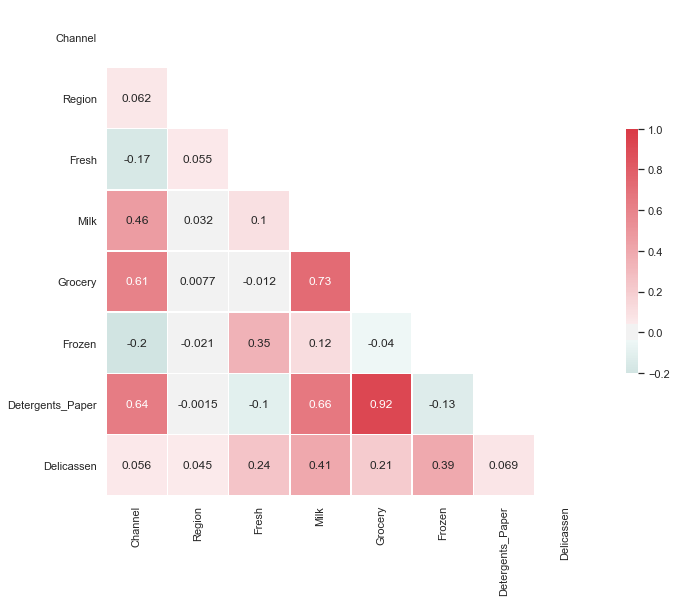

In [6]:
#Column collinearity - any high correlations?

import seaborn as sns


corr = customers.corr()
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(180, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, annot = True, linewidths=.5, cbar_kws={"shrink": .5})

'''
It is possible to observe high correlation between some variables.
'''

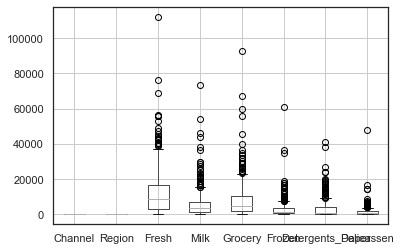

In [7]:
#Descriptive statistics - any outliers to remove?

customers.boxplot()
#Looking at the boxplot, we can see that there's a lot of outliers that can be removed.
#For a better understanding, we can see them by using the IQR.

In [8]:
#Looking the IQR for outliers:
    
#Calculating limits and IQR:
Q1 = customers.quantile(0.25)
Q3 = customers.quantile(0.75)
IQR = Q3 - Q1
lower_limit = Q1 - 1.5* IQR
upper_limit = Q3 + 1.5* IQR

In [9]:
#Checking the OUTLIERS:
customers[(customers < lower_limit) | (customers > upper_limit)]
#The NaN values are inside the limits. We should drop the others.

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7844.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5185.0
...,...,...,...,...,...,...,...,...
435,NaN,NaN,NaN,NaN,NaN,13135.0,NaN,NaN
436,NaN,NaN,39228.0,NaN,NaN,NaN,NaN,NaN
437,NaN,NaN,NaN,NaN,30243.0,NaN,14841.0,NaN
438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Challenge 2 - Data Cleaning and Transformation

If your conclusion from the previous challenge is the data need cleaning/transformation, do it in the cells below. However, if your conclusion is the data need not be cleaned or transformed, feel free to skip this challenge. But if you do choose the latter, please provide rationale.

In [10]:
# Dropping the previously detected outliers:
customers[(customers < lower_limit) | (customers > upper_limit)]

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7844.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5185.0
...,...,...,...,...,...,...,...,...
435,NaN,NaN,NaN,NaN,NaN,13135.0,NaN,NaN
436,NaN,NaN,39228.0,NaN,NaN,NaN,NaN,NaN
437,NaN,NaN,NaN,NaN,30243.0,NaN,14841.0,NaN
438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
customers_cleaned = customers[(customers > lower_limit) & (customers < upper_limit)].dropna()


#Cleaned dataframe:
customers_cleaned

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669.0,9656.0,7561.0,214.0,2674.0,1338.0
1,2,3,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0
3,1,3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0
5,2,3,9413.0,8259.0,5126.0,666.0,1795.0,1451.0
6,2,3,12126.0,3199.0,6975.0,480.0,3140.0,545.0
...,...,...,...,...,...,...,...,...
432,1,3,21117.0,1162.0,4754.0,269.0,1328.0,395.0
433,1,3,1982.0,3218.0,1493.0,1541.0,356.0,1449.0
434,1,3,16731.0,3922.0,7994.0,688.0,2371.0,838.0
438,1,3,10290.0,1981.0,2232.0,1038.0,168.0,2125.0


In [12]:
'''
I cleaned it because there were values outside the limits. There may be another way to do it with the Z-score, but I will keep
what I did for now.
url = https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba
'''

'\nI cleaned it because there were values outside the limits. There may be another way to do it with the Z-score, but I will keep\nwhat I did for now.\nurl = https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba\n'

# Challenge 3 - Data Preprocessing

One problem with the dataset is the value ranges are remarkably different across various categories (e.g. `Fresh` and `Grocery` compared to `Detergents_Paper` and `Delicassen`). If you made this observation in the first challenge, you've done a great job! This means you not only completed the bonus questions in the previous Supervised Learning lab but also researched deep into [*feature scaling*](https://en.wikipedia.org/wiki/Feature_scaling). Keep on the good work!

Diverse value ranges in different features could cause issues in our clustering. The way to reduce the problem is through feature scaling. We'll use this technique again with this dataset.

#### We will use the `StandardScaler` from `sklearn.preprocessing` and scale our data. Read more about `StandardScaler` [here](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler).

*After scaling your data, assign the transformed data to a new variable `customers_scale`.*

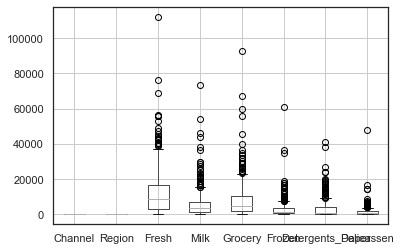

In [13]:
customers.boxplot()

In [14]:
# Your import here:

from sklearn.preprocessing import StandardScaler

# Your code here:
scaler = StandardScaler()
customers_scale = scaler.fit_transform(customers_cleaned)
#I had to fit the data ans then transform it.

In [15]:
customers_scale

array([[ 1.5794736 ,  0.59009178,  0.38304079, ..., -0.96700429,
         0.30505322,  0.3904653 ],
       [ 1.5794736 ,  0.59009178, -0.30558788, ..., -0.05925481,
         0.56913935,  0.92259064],
       [-0.63312233,  0.59009178,  0.45617384, ...,  2.66282084,
        -0.61946154,  0.93716941],
       ...,
       [-0.63312233,  0.59009178,  0.88147444, ..., -0.68904999,
         0.17578328, -0.21698372],
       [-0.63312233,  0.59009178,  0.09112211, ..., -0.48380948,
        -0.76409029,  1.34659005],
       [-0.63312233,  0.59009178, -0.82954447, ..., -1.05437811,
        -0.63226055, -1.17189357]])

# Challenge 4 - Data Clustering with K-Means

Now let's cluster the data with K-Means first. Initiate the K-Means model, then fit your scaled data. In the data returned from the `.fit` method, there is an attribute called `labels_` which is the cluster number assigned to each data record. What you can do is to assign these labels back to `customers` in a new column called `customers['labels']`. Then you'll see the cluster results of the original data.

In [16]:
# Initiating the model:
from sklearn import cluster

kmeans = cluster.KMeans(n_clusters = 2, random_state = 0)
kmeans.fit(customers_scale)
print(kmeans.labels_)

#Assigning the labels to a new column:
customers_cleaned['labels'] = kmeans.labels_
print(customers_cleaned)

[1 1 0 1 1 1 0 1 1 0 1 1 1 0 1 1 0 1 0 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1
 0 0 1 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 0 0 1 1 1 0 0 1
 1 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0
 1 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0
 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0]
     Channel  Region    Fresh    Milk  Grocery  Frozen  Detergents_Paper  \
0          2       3  12669.0  9656.0   7561.0   214.0            2674.0   
1          2       3   7057.0  9810.0   9568.0  1762.0            3293.0   
3          1       3  13265.0  1196.0   4221.0  6404.0             507.0   
5          2       3  

Count the values in `labels`.

In [17]:
# Your code here:
customers_cleaned['labels'].value_counts()
#Looks like we have imbalance.

0    233
1     99
Name: labels, dtype: int64

# Challenge 5 - Data Clustering with DBSCAN

Now let's cluster the data using DBSCAN. Use `DBSCAN(eps=0.5)` to initiate the model, then fit your scaled data. In the data returned from the `.fit` method, assign the `labels_` back to `customers['labels_DBSCAN']`. Now your original data have two labels, one from K-Means and the other from DBSCAN.

In [18]:
# Your code here
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps = 0.5)
dbscan.fit(customers_scale)
print(dbscan.labels_)

[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1  0  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1  0
  0  0 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0
 -1 -1  0 -1 -1 -1 -1  0 -1 -1  0 -1  0  0 -1  0 -1  0  0 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  0 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1

Count the values in `labels_DBSCAN`.

In [30]:
# Your code here
customers_cleaned['labels_DBSCAN'] = dbscan.labels_
customers_cleaned

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels,labels_DBSCAN
0,2,3,12669.0,9656.0,7561.0,214.0,2674.0,1338.0,1,-1
1,2,3,7057.0,9810.0,9568.0,1762.0,3293.0,1776.0,1,-1
3,1,3,13265.0,1196.0,4221.0,6404.0,507.0,1788.0,0,-1
5,2,3,9413.0,8259.0,5126.0,666.0,1795.0,1451.0,1,-1
6,2,3,12126.0,3199.0,6975.0,480.0,3140.0,545.0,1,-1
...,...,...,...,...,...,...,...,...,...,...
432,1,3,21117.0,1162.0,4754.0,269.0,1328.0,395.0,0,-1
433,1,3,1982.0,3218.0,1493.0,1541.0,356.0,1449.0,0,-1
434,1,3,16731.0,3922.0,7994.0,688.0,2371.0,838.0,0,-1
438,1,3,10290.0,1981.0,2232.0,1038.0,168.0,2125.0,0,-1


# Challenge 6 - Compare K-Means with DBSCAN

Now we want to visually compare how K-Means and DBSCAN have clustered our data. We will create scatter plots for several columns. For each of the following column pairs, plot a scatter plot using `labels` and another using `labels_DBSCAN`. Put them side by side to compare. Which clustering algorithm makes better sense?

Columns to visualize:

* `Detergents_Paper` as X and `Milk` as y
* `Grocery` as X and `Fresh` as y
* `Frozen` as X and `Delicassen` as y

Visualize `Detergents_Paper` as X and `Milk` as y by `labels` and `labels_DBSCAN` respectively

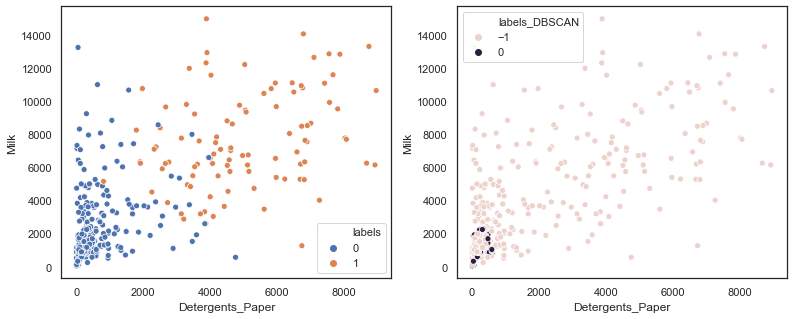

In [41]:
# Plots:
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.scatterplot(x = customers_cleaned['Detergents_Paper'], y = customers_cleaned['Milk'], hue = customers_cleaned['labels'], ax = ax[0])
sns.scatterplot(x = customers_cleaned['Detergents_Paper'], y = customers_cleaned['Milk'], hue = customers_cleaned['labels_DBSCAN'], ax = ax[1])
plt.show()

Visualize `Grocery` as X and `Fresh` as y by `labels` and `labels_DBSCAN` respectively

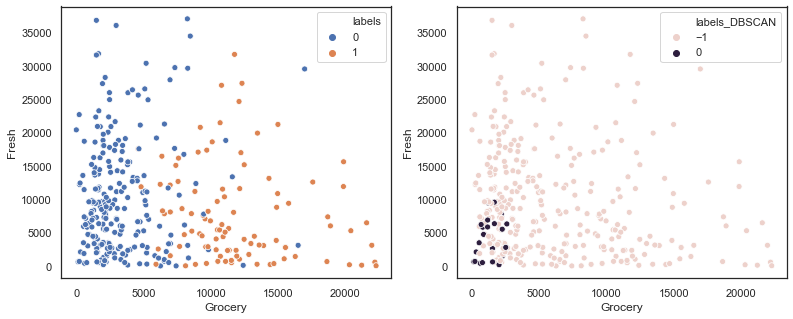

In [42]:
# Your code here:
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.scatterplot(x = customers_cleaned['Grocery'], y = customers_cleaned['Fresh'], hue = customers_cleaned['labels'], ax = ax[0])
sns.scatterplot(x = customers_cleaned['Grocery'], y = customers_cleaned['Fresh'], hue = customers_cleaned['labels_DBSCAN'], ax = ax[1])
plt.show()

Visualize `Frozen` as X and `Delicassen` as y by `labels` and `labels_DBSCAN` respectively

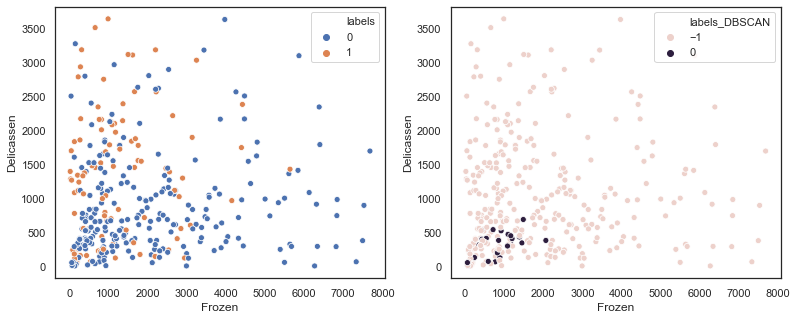

In [43]:
# Your code here:
fig, ax = plt.subplots(1,2, figsize=(13,5))
sns.scatterplot(x = customers_cleaned['Frozen'], y = customers_cleaned['Delicassen'], hue = customers_cleaned['labels'], ax = ax[0])
sns.scatterplot(x = customers_cleaned['Frozen'], y = customers_cleaned['Delicassen'], hue = customers_cleaned['labels_DBSCAN'], ax = ax[1])
plt.show()

Let's use a groupby to see how the mean differs between the groups. Group `customers` by `labels` and `labels_DBSCAN` respectively and compute the means for all columns.

In [44]:
# For the KMeans:
customers_cleaned.groupby('labels').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels_DBSCAN
labels,,,,,,,,,
0,1.017167,2.480687,10320.025751,2596.206009,3325.901288,2120.824034,660.261803,879.291845,-0.896996
1,1.919192,2.676768,7728.989899,7656.606061,11876.454545,1256.363636,5015.545455,1339.767677,-1.000000


In [45]:
# For the DBSCAN:
customers_cleaned.groupby('labels_DBSCAN').mean()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,labels
labels_DBSCAN,,,,,,,,,
-1,1.308442,2.503247,9952.808442,4337.454545,6223.438312,1942.230519,2093.649351,1070.172078,0.321429
0,1.000000,3.000000,4344.625000,1124.333333,1411.875000,846.875000,230.666667,329.125000,0.000000


Which algorithm appears to perform better?

In [24]:
# Your observations here
#DBSCAN appears to be more suitable than KMeans in this case. The cluster are more perceptible/better defined than the KMeans clusters.

# Bonus Challenge 1 - Changing K-Means Number of Clusters

As we mentioned earlier, we don't need to worry about the number of clusters with DBSCAN because it automatically decides that based on the parameters we send to it. But with K-Means, we have to supply the `n_clusters` param (if you don't supply `n_clusters`, the algorithm will use `8` by default). You need to know that the optimal number of clusters differs case by case based on the dataset. K-Means can perform badly if the wrong number of clusters is used.

In advanced machine learning, data scientists try different numbers of clusters and evaluate the results with statistical measures (read [here](https://en.wikipedia.org/wiki/Cluster_analysis#External_evaluation)). We are not using statistical measures today but we'll use our eyes instead. In the cells below, experiment with different number of clusters and visualize with scatter plots. What number of clusters seems to work best for K-Means?

In [25]:
# Your code here

In [26]:
# Your comment here

# Bonus Challenge 2 - Changing DBSCAN `eps` and `min_samples`

Experiment changing the `eps` and `min_samples` params for DBSCAN. See how the results differ with scatter plot visualization.

In [27]:
# Your code here

In [28]:
# Your comment here